# Emotions Classifier

## Connection au Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content


## "Dezippage" du Dataset depuis la VM

In [ ]:
# Better copy data from Drive as an archive
zip_path = '/content/gdrive/My Drive/Emotions/dataset/data.zip'

!cp "{zip_path}" .

!unzip -q data.zip

# Remove .zip file after you unzip it
!rm data.zip

# Make sure it's there
!ls

data  gdrive  sample_data


## Import des modules 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot
import cv2
import os
import glob
from tensorflow.keras.utils import to_categorical  
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

In [ ]:
emotion = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3,
           'sad': 4, 'surprise': 5, 'neutral': 6}

## Création des matrices de features et labels

In [ ]:
def create_x_y(test=False):
    X = []
    y = []
    if test:
        path = os.getcwd()+'/dataset/test'
    else:
        path = os.getcwd()+'/dataset/train'
    labels_folders = os.listdir(path)
    for folder in labels_folders:
        path_2 = path+f'/{folder}'
        print('Lecture path : ', path_2)
        images = [cv2.imread(file, 0) for file in glob.glob(f'{path_2}/*.jpg')]
        for image in images:
            img = cv2.resize(image, (48, 48))
            X.append(img)
            y.append(emotion[folder])
    X = np.array(X)
    X = X.reshape(X.shape[0], 48, 48,1)
    X = X.astype("float32")
    X /= 255
    return X, np.array(y) 

X_train, y_train = create_x_y()
X_test, y_test = create_x_y(test=True)

Lecture path :  /content/data/train/sad
Lecture path :  /content/data/train/neutral
Lecture path :  /content/data/train/surprise
Lecture path :  /content/data/train/angry
Lecture path :  /content/data/train/disgust
Lecture path :  /content/data/train/happy
Lecture path :  /content/data/train/fear
Lecture path :  /content/data/test/sad
Lecture path :  /content/data/test/neutral
Lecture path :  /content/data/test/surprise
Lecture path :  /content/data/test/angry
Lecture path :  /content/data/test/disgust
Lecture path :  /content/data/test/happy
Lecture path :  /content/data/test/fear


In [ ]:
y_train = to_categorical(y_train, 7)
y_test = to_categorical(y_test, 7)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(28709, 48, 48, 1)
(7178, 48, 48, 1)
(28709, 7)
(7178, 7)


## Mélange aléatoire des features et labels train / test

In [ ]:
indices_train = np.arange(X_train.shape[0])
np.random.shuffle(indices_train)

X_train = X_train[indices_train]
y_train = y_train[indices_train]

In [ ]:
indices_test = np.arange(X_test.shape[0])
np.random.shuffle(indices_test)

X_test = X_test[indices_test]
y_test = y_test[indices_test]

## Définition du modèle

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(64,kernel_size=(5,5),input_shape=(48, 48, 1),activation='elu', padding='same', kernel_initializer='he_normal'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, kernel_size=(5,5), activation='elu', padding='same', kernel_initializer='he_normal'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv2D(128, kernel_size=(3,3), activation='elu', padding='same', kernel_initializer='he_normal'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, kernel_size=(3,3), activation='elu', padding='same', kernel_initializer='he_normal'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv2D(256, kernel_size=(3,3), activation='elu', padding='same', kernel_initializer='he_normal'))
model.add(layers.BatchNormalization(name='batchnorm_5'))
model.add(layers.Conv2D(256, kernel_size=(3,3), activation='elu', padding='same', kernel_initializer='he_normal'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='elu', kernel_initializer='he_normal'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.6))
model.add(layers.Dense(7, activation='softmax')
)

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 48, 48, 64)        1664      
_________________________________________________________________
batch_normalization_18 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization_19 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 24, 24, 128)      

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
batch_size = 32
epochs = 100

#Augmentation du dataset
aug = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)

aug.fit(X_train)

#Arrête l'entrainement afin d'éviter le sur-appprentissage
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

#Diminue le learning rate au cours de l'entrainement lorsque l'accuracy sur les données de validations à cessé de s'améliorer
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [early_stopping, lr_scheduler,
]

model.fit(aug.flow(X_train, y_train, batch_size=batch_size), epochs=epochs, steps_per_epoch=len(X_train) / batch_size, validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/100
897/897 [==============================] - 21s 24ms/step - loss: 0.8688 - accuracy: 0.6817 - val_loss: 0.8978 - val_accuracy: 0.6831
Epoch 2/100
897/897 [==============================] - 21s 24ms/step - loss: 0.8727 - accuracy: 0.6805 - val_loss: 0.8954 - val_accuracy: 0.6832
Epoch 3/100
897/897 [==============================] - 21s 24ms/step - loss: 0.8655 - accuracy: 0.6849 - val_loss: 0.8964 - val_accuracy: 0.6828
Epoch 4/100
897/897 [==============================] - 21s 24ms/step - loss: 0.8683 - accuracy: 0.6807 - val_loss: 0.9029 - val_accuracy: 0.6800
Epoch 5/100
897/897 [==============================] - 22s 24ms/step - loss: 0.8588 - accuracy: 0.6859 - val_loss: 0.9055 - val_accuracy: 0.6783
Epoch 6/100
897/897 [==============================] - 22s 24ms/step - loss: 0.8552 - accuracy: 0.6862 - val_loss: 0.8986 - val_accuracy: 0.6793
Epoch 7/100
897/897 [==============================] - 22s 24ms/step - loss: 0.8577 - accuracy: 0.6849 - val_loss: 0.8986 - val_ac

In [ ]:
#!pip install pyyaml h5py
model.save('/content/gdrive/My Drive/Emotions/emotions_classifer')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Emotions/emotions_classifer_2/assets


## Evaluation

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print("Précision : ", test_acc)

225/225 [==============================] - 2s 8ms/step - loss: 0.8955 - accuracy: 0.6881
Précision :  0.6880746483802795


## Predictions

In [ ]:
predictions = (model.predict(X_test) > 0.5).astype("int32")

## Matrice de confusion

In [ ]:
print(len(predictions))
print(len(y_test))

7178
7178


In [ ]:
classes_pred = []
classes_test = []

for pred, test in zip(predictions, y_test):
  try:
    label_pred = np.where(pred == 1)[0][0]
    label_test = np.where(test == 1)[0][0]
    classes_pred.append(label_pred)
    classes_test.append(label_test)
  except:
    continue


In [ ]:
print(len(classes_pred))
print(len(classes_test))

5961
5961


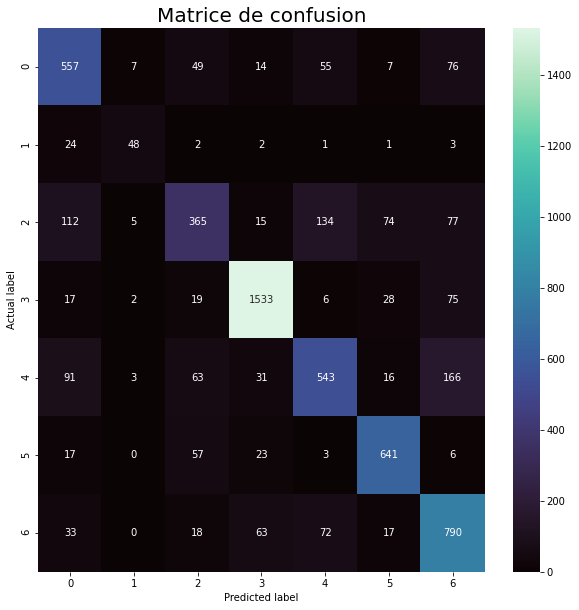

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

cm = metrics.confusion_matrix(classes_test, classes_pred)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt=".0f", cmap = 'mako')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title("Matrice de confusion", size = 20)
plt.show()